In [46]:
import pandas as pd
import os
from datetime import datetime
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
train_df = pd.read_csv(os.path.abspath('../input/cleaned-2007-2017.csv'))

In [19]:
train_df['datetime'] = train_df['date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))

In [20]:
train_df_gt_2008 = train_df[train_df['datetime'] > '2008-01-01']

In [22]:
surfaces = [('H','H'),('H','C'),('H','G'),('C','H'), ('C','C'), ('C','G'),('G','H'), ('G','C'), ('G','G')]

In [64]:
matches_won_by_surface = {'H':[], 'C':[], 'G':[]}

for surface in tqdm(['H','C','G'],desc='surfaces'):
    for player_id in tqdm(pd.Series(np.concatenate((np.array(train_df['player_id']), np.array(train_df['opponent_id'])))).unique(),desc='players ' + surface):
        player_matches = train_df[((train_df['player_id'] == player_id) | (train_df['opponent_id'] == player_id)) & (train_df['surface'] == surface)]
        p_matches_won_surface = 0
        for index, row in player_matches.iterrows():
            if(row['player_id'] == player_id):
                p_matches_won_surface += row['p_matches']
            elif(row['p_matches'] == 0):
                p_matches_won_surface += 1
        p_matches_won_surface = p_matches_won_surface / player_matches['p_matches'].count()
        matches_won_by_surface[surface].append(p_matches_won_surface)

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


In [88]:
surface_df = pd.DataFrame({
                            'H': np.array(matches_won_by_surface['H']), #[~np.isnan(np.array(matches_won_by_surface['H']))],
                            'C': np.array(matches_won_by_surface['C']), #[~np.isnan(np.array(matches_won_by_surface['C']))],
                            'G': np.array(matches_won_by_surface['G']), #[~np.isnan(np.array(matches_won_by_surface['G']))]
                            'player_id': pd.Series(np.concatenate((np.array(train_df['player_id']), np.array(train_df['opponent_id'])))).unique()
                        })

In [89]:
H_column = []
C_column = []
G_column = []

for a,b in surfaces:
    correlation = 0
    numerator_correlation = 0
    surface_non_null = surface_df.dropna(subset=[a, b])
    n_minus_1 = len(surface_non_null.index) - 1
    std_a = surface_non_null[a].std()
    std_b = surface_non_null[b].std()
    for player_index in surface_non_null.index:
        numerator_correlation += (surface_non_null[a][player_index] - surface_non_null[a].mean()) *  (surface_non_null[b][player_index] - surface_non_null[b].mean())
    correlation = numerator_correlation / (n_minus_1 * std_a * std_b)
    if(a == 'H'):
        H_column.append(correlation)
    elif(a == 'C'):
        C_column.append(correlation)
    elif(a == 'G'):
        G_column.append(correlation)

In [90]:
surface_correlations = pd.DataFrame({
                'H': H_column,
                'C': C_column,
                'G': G_column
             }, index=['H', 'C', 'G'])

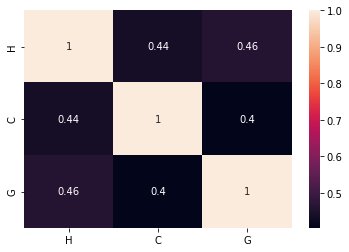

In [91]:
fig, ax = plt.subplots()
sns.heatmap(surface_correlations, annot=True)
ax.set_ylim(len(surface_correlations), 0)
plt.show()

In [ ]:
from tqdm.notebook import tqdm

# player 1 columns
p_fs_column = []
p_w1sp_column = []
p_w2sp_column = []
p_wrp_column = []
p_tpw_column = []
p_tmw_column = []
p_aces_per_game_column = []
p_df_per_game_column = []
p_bp_won_column = []

# Combining statistics
p_wsp_column = []
p_completeness_column = []

p_h2h_column = []

p_number_of_matches_used_column = []

#player 2 columns
o_fs_column = []
o_w1sp_column = []
o_w2sp_column = []
o_wrp_column = []
o_tpw_column = []
o_tmw_column = []
o_aces_per_game_column = []
o_df_per_game_column = []
o_bp_won_column = []

# Combining statistics
o_wsp_column = []
o_completeness_column = []

o_h2h_column = []

o_number_of_matches_used_column = []

# Combining statistics from the two players
p_serve_adv_column = []
o_serve_adv_column = []
direct_column = []

# matches to include (for development, no need for final dataset generation)
number_of_matches_to_include = 2000

# time discounting coefficient
time_discounting = 0.8

pbar = tqdm(total=train_df_gt_2008.head(n=number_of_matches_to_include).shape[0])

for index, row in train_df_gt_2008.head(n=number_of_matches_to_include).iterrows():
    # filter dataset to keep only player matches prior to current match
    filtered_dataset = train_df[
        (train_df['datetime'] < datetime.strptime(row['date'], '%d/%m/%Y')) 
        & (train_df['player_id'] == row['player_id'])
    ]

    # initialize temp variables to calculate features
    p_1st_in = p_sv_pt = p_1st_won = p_2nd_won = o_sv_pt = o_1st_won = o_2nd_won = o_sv_pt = p_matches \
    = o_matches = p_ace = p_df = p_sv_gms = p_bp_sv = o_bp_sv = p_bp_fc = o_bp_fc = p_number_of_matches_used = 0

    # initialize variable features
    p_fs = p_w1sp = p_w2sp = p_wrp = p_tpw = p_tmw = p_aces_per_game = p_df_per_game = p_bp_won = p_wsp = p_completeness = p_h2h = np.nan

    # calculate statistics averaging with time discounting and surface weighting for player 1
    if(filtered_dataset.shape[0] != 0):
        for f_index, f_row in filtered_dataset.iterrows():
            time_diff = row['datetime'].year - f_row['datetime'].year
            surface_weight = surface_correlations[row['surface']].loc[f_row['surface']]
            p_1st_in += f_row['p_1st_in'] * (time_discounting ** time_diff) * surface_weight
            p_sv_pt += f_row['p_sv_pt'] * (time_discounting ** time_diff) * surface_weight
            p_1st_won += f_row['p_1st_won'] * (time_discounting ** time_diff) * surface_weight
            p_2nd_won += f_row['p_2nd_won'] * (time_discounting ** time_diff) * surface_weight
            o_sv_pt += f_row['o_sv_pt'] * (time_discounting ** time_diff) * surface_weight
            o_1st_won += f_row['o_1st_won'] * (time_discounting ** time_diff) * surface_weight
            o_2nd_won += f_row['o_2nd_won'] * (time_discounting ** time_diff) * surface_weight
            o_sv_pt += f_row['o_sv_pt'] * (time_discounting ** time_diff) * surface_weight
            p_matches += f_row['p_matches'] * (time_discounting ** time_diff) * surface_weight
            o_matches += f_row['o_matches'] * (time_discounting ** time_diff) * surface_weight
            p_ace += f_row['p_ace'] * (time_discounting ** time_diff) * surface_weight
            p_df += f_row['p_df'] * (time_discounting ** time_diff) * surface_weight
            p_sv_gms += f_row['p_sv_gms'] * (time_discounting ** time_diff) * surface_weight
            p_bp_sv += f_row['p_bp_sv'] * (time_discounting ** time_diff) * surface_weight
            o_bp_sv += f_row['o_bp_sv'] * (time_discounting ** time_diff) * surface_weight
            p_bp_fc += f_row['p_bp_fc'] * (time_discounting ** time_diff) * surface_weight
            o_bp_fc += f_row['o_bp_fc'] * (time_discounting ** time_diff) * surface_weight

        ## Compute features 

        # first serve sucess percentage
        p_fs = p_1st_in / p_sv_pt

        # winning on first serve percentage
        p_w1sp = p_1st_won / p_1st_in

        # winning on second serve percentage
        p_w2sp = p_2nd_won / (p_sv_pt - p_1st_in)
        
        # winning on return percentage
        p_wrp = (o_sv_pt - o_1st_won - o_2nd_won) / o_sv_pt
        
        # percentage of all points won
        p_tpw = (p_1st_won + p_2nd_won + (o_sv_pt - o_1st_won - o_2nd_won) ) / (p_sv_pt + o_sv_pt)
        
        # percentage of all matches won
        p_tmw = p_matches / (p_matches + o_matches)
        
        # Average number of aces per game
        p_aces_per_game = p_ace / p_sv_gms
        
        # Average number of double faults per game
        p_df_per_game = p_df / p_sv_gms
        
        # Percentage of breakpoints won
        p_bp_won = (p_bp_sv + o_bp_sv) / (p_bp_fc + o_bp_fc)
        
        # overall winning percentage
        p_wsp = p_w1sp * p_fs + p_w2sp * (1-p_fs)
        
        # completeness
        p_completeness = p_wsp * p_wrp
        
        
        
        # number of matches used to compute statistics
        p_number_of_matches_used = filtered_dataset.shape[0]

    p_fs_column.append(p_fs)
    p_w1sp_column.append(p_w1sp)
    p_w2sp_column.append(p_w2sp)
    p_wrp_column.append(p_wrp)
    p_tpw_column.append(p_tpw)
    p_tmw_column.append(p_tmw)
    p_aces_per_game_column.append(p_aces_per_game)
    p_df_per_game_column.append(p_df_per_game)
    p_bp_won_column.append(p_bp_won)
    
    # Combining statistics
    p_wsp_column.append(p_wsp)
    p_completeness_column.append(p_completeness)
    
    ## head to head feature
    # filter dataset to keep only player matches prior to current match
    filtered_dataset_h2h = train_df[
        (train_df['datetime'] < datetime.strptime(row['date'], '%d/%m/%Y')) 
        & (train_df['player_id'] == row['player_id'])
        & (train_df['opponent_id'] == row['opponent_id'])
    ]
    if(filtered_dataset_h2h.shape[0] != 0):
        p_h2h = filtered_dataset_h2h['p_matches'].sum() / filtered_dataset_h2h['p_matches'].count()
    p_h2h_column.append(p_h2h)

    # number of matches computed to have stats
    p_number_of_matches_used_column.append(p_number_of_matches_used)
    
    #------------------------------------------------------------------------------------------------------------------
    
    # filter dataset to keep only opponent matches prior to current match
    filtered_dataset = train_df[
        (train_df['datetime'] < datetime.strptime(row['date'], '%d/%m/%Y')) 
        & (train_df['player_id'] == row['opponent_id'])
    ]

    # initialize temp variables to calculate features
    p_1st_in = p_sv_pt = p_1st_won = p_2nd_won = o_sv_pt = o_1st_won = o_2nd_won = o_sv_pt = p_matches \
    = o_matches = p_ace = p_df = p_sv_gms = p_bp_sv = o_bp_sv = p_bp_fc = o_bp_fc = o_number_of_matches_used = 0

    # initialize variable features
    o_fs = o_w1sp = o_w2sp = o_wrp = o_tpw = o_tmw = o_aces_per_game = o_df_per_game = o_bp_won = o_wsp = o_completeness = o_h2h = np.nan

    # calculate statistics averaging with time discounting and surface weighting for player 2
    if(filtered_dataset.shape[0] != 0):
        for f_index, f_row in filtered_dataset.iterrows():
            time_diff = row['datetime'].year - f_row['datetime'].year
            surface_weight = surface_correlations[row['surface']].loc[f_row['surface']]
            p_1st_in += f_row['p_1st_in'] * (time_discounting ** time_diff) * surface_weight
            p_sv_pt += f_row['p_sv_pt'] * (time_discounting ** time_diff) * surface_weight
            p_1st_won += f_row['p_1st_won'] * (time_discounting ** time_diff) * surface_weight
            p_2nd_won += f_row['p_2nd_won'] * (time_discounting ** time_diff) * surface_weight
            o_sv_pt += f_row['o_sv_pt'] * (time_discounting ** time_diff) * surface_weight
            o_1st_won += f_row['o_1st_won'] * (time_discounting ** time_diff) * surface_weight
            o_2nd_won += f_row['o_2nd_won'] * (time_discounting ** time_diff) * surface_weight
            o_sv_pt += f_row['o_sv_pt'] * (time_discounting ** time_diff) * surface_weight
            p_matches += f_row['p_matches'] * (time_discounting ** time_diff) * surface_weight
            o_matches += f_row['o_matches'] * (time_discounting ** time_diff) * surface_weight
            p_ace += f_row['p_ace'] * (time_discounting ** time_diff) * surface_weight
            p_df += f_row['p_df'] * (time_discounting ** time_diff) * surface_weight
            p_sv_gms += f_row['p_sv_gms'] * (time_discounting ** time_diff) * surface_weight
            p_bp_sv += f_row['p_bp_sv'] * (time_discounting ** time_diff) * surface_weight
            o_bp_sv += f_row['o_bp_sv'] * (time_discounting ** time_diff) * surface_weight
            p_bp_fc += f_row['p_bp_fc'] * (time_discounting ** time_diff) * surface_weight
            o_bp_fc += f_row['o_bp_fc'] * (time_discounting ** time_diff) * surface_weight
            
        ## Compute features 

        # first serve sucess percentage
        o_fs = p_1st_in / p_sv_pt

        # winning on first serve percentage
        o_w1sp = p_1st_won / p_1st_in

        # winning on second serve percentage
        o_w2sp = p_2nd_won / (p_sv_pt - p_1st_in)
        
        # winning on return percentage
        o_wrp = (o_sv_pt - o_1st_won - o_2nd_won) / o_sv_pt
        
        # percentage of all points won
        o_tpw = (p_1st_won + p_2nd_won + (o_sv_pt - o_1st_won - o_2nd_won) ) / (p_sv_pt + o_sv_pt)
        
        # percentage of all matches won
        o_tmw = p_matches / (p_matches + o_matches)
        
        # Average number of aces per game
        o_aces_per_game = p_ace / p_sv_gms
        
        # Average number of double faults per game
        o_df_per_game = p_df / p_sv_gms
        
        # Percentage of breakpoints won
        o_bp_won = (p_bp_sv + o_bp_sv) / (p_bp_fc + o_bp_fc)
        
        ## Combining features to obtain more stats
        
        # overall winning percentage
        o_wsp = o_w1sp * o_fs + o_w2sp * (1-o_fs)
        
        # completeness
        o_completeness = o_wsp * o_wrp
        
        
        
        # number of matches used to compute statistics
        o_number_of_matches_used = filtered_dataset.shape[0]

    o_fs_column.append(o_fs)
    o_w1sp_column.append(o_w1sp)
    o_w2sp_column.append(o_w2sp)
    o_wrp_column.append(o_wrp)
    o_tpw_column.append(o_tpw)
    o_tmw_column.append(o_tmw)
    o_aces_per_game_column.append(o_aces_per_game)
    o_df_per_game_column.append(o_df_per_game)
    o_bp_won_column.append(o_bp_won)
    
    # Combining statistics
    o_wsp_column.append(o_wsp)
    o_completeness_column.append(o_completeness)
    
    ## head to head feature
    # filter dataset to keep only player matches prior to current match
    filtered_dataset_h2h = train_df[
        (train_df['datetime'] < datetime.strptime(row['date'], '%d/%m/%Y')) 
        & (train_df['player_id'] == row['opponent_id'])
        & (train_df['opponent_id'] == row['player_id'])
    ]
    if(filtered_dataset_h2h.shape[0] != 0):
        o_h2h = filtered_dataset_h2h['p_matches'].sum() / filtered_dataset_h2h['p_matches'].count()
    o_h2h_column.append(o_h2h)
    

    # number of matches computed to have stats
    o_number_of_matches_used_column.append(o_number_of_matches_used)
    
    # Combining statistics from the two players
    p_serve_adv_column = (np.array(p_wsp_column) - np.array(o_wrp_column)).tolist()
    o_serve_adv_column = (np.array(o_wsp_column) - np.array(p_wrp_column)).tolist()
    direct_column = (np.array(p_h2h_column) - np.array(o_h2h_column)).tolist()
    
    # progress
    pbar.update(1)
    
pbar.close()

result_test_df = pd.DataFrame({'p_fs': p_fs_column, 'p_w1sp': p_w1sp_column, 'p_w2sp': p_w2sp_column, 'p_wrp': p_wrp_column, 
                               'p_tpw': p_tpw_column, 'p_tmw': p_tmw_column, 'p_aces_per_game': p_aces_per_game_column,
                               'p_df_per_game': p_df_per_game_column, 'p_bp_won': p_bp_won_column,
                               'p_wsp': p_wsp_column, 'p_completeness': p_completeness_column, 'p_serve_adv': p_serve_adv_column,
                               'p_number_of_matches_used': p_number_of_matches_used_column,
                               'o_fs': o_fs_column, 'o_w1sp': o_w1sp_column, 'o_w2sp': o_w2sp_column, 'o_wrp': o_wrp_column, 
                               'o_tpw': o_tpw_column, 'o_tmw': o_tmw_column, 'o_aces_per_game': o_aces_per_game_column,
                               'o_df_per_game': o_df_per_game_column, 'o_bp_won': o_bp_won_column,
                               'o_wsp': o_wsp_column, 'o_completeness': o_completeness_column, 'o_serve_adv': o_serve_adv_column,
                               'direct': direct_column,
                               'o_number_of_matches_used': o_number_of_matches_used_column
                              })